# More Introduction to Quantum Computing

## MITP 2023

Here we introduce even more quantum computing! Again, we will concentrate on using Qiskit and PennyLane, but these skills will be transferable to other languages. 

Here we will consider useful algorithms which will be used later in the course, or more widely in Quantum Machine Learning (QML).

In [1]:
### Import required packages
import numpy as np
import matplotlib.pyplot as plt
from qiskit import (QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute, transpile)
from qiskit.quantum_info import Statevector
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import *
### Define simulator
sim = Aer.get_backend('qasm_simulator')

## Qiskit

## The SWAP Test

First introduced in Refs [1] and [2], the SWAP test is a small algorithm which determines how close two quantum states $\vert \phi \rangle$ and $\vert \psi \rangle$ are. The test is very common in quantum machine learning.

The circuit is very simple and consists of three operations on three qubits: the ancilla qubit $a$, the $\phi$ qubit in the $\vert \phi \rangle$ state, and the $\psi$ qubit in the $\vert \psi \rangle$ state.

/home/kk423/.conda/envs/ML_env_mini/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


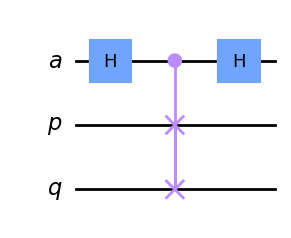

In [2]:
### Define quantum registers
phi = QuantumRegister(1, name='p')
psi = QuantumRegister(1, name='q')
a   = QuantumRegister(1, name='a')

swapTest = QuantumCircuit(a, phi, psi)

swapTest.h(a)
swapTest.cswap(a, phi, psi)
swapTest.h(a)

swapTest.draw('mpl')

The first Hadamard operaton puts the ancilla qubit $a$ into a linear superposition of the computation basis

$$
\vert 0 \rangle \otimes \vert \phi \rangle \otimes \vert \psi \rangle \xrightarrow{H} \frac{1}{\sqrt{2}} \big(\vert 0 \rangle + \vert 1 \rangle\big) \otimes \vert \phi \rangle \otimes \vert \psi \rangle.
$$

The controlled-SWAP gate is then applied across all three qubits, controlled from the ancilla. If the ancilla is in the $\vert 1 \rangle$ state, the SWAP operation is applied to the $p$ and $q$ qubits, swapping the states of the qubits.

$$
\frac{1}{\sqrt{2}} \big(\vert 0 \rangle + \vert 1 \rangle\big) \otimes \vert \phi \rangle \otimes \vert \psi \rangle \xrightarrow{cSWAP} \frac{1}{\sqrt{2}} \vert 0 \rangle \otimes \vert \phi \rangle \otimes \vert \psi \rangle + \frac{1}{\sqrt{2}} \vert 1 \rangle \otimes \vert \psi \rangle \otimes \vert \phi \rangle.
$$

A second Hadamard gate is then applied to the ancilla qubit

$$
\frac{1}{\sqrt{2}} \vert 0 \rangle \otimes \vert \phi \rangle \otimes \vert \psi \rangle + \frac{1}{\sqrt{2}} \vert 1 \rangle \otimes \vert \psi \rangle \otimes \vert \phi \rangle \xrightarrow{H} \frac{1}{2} \Bigg( \big(\vert 0 \rangle + \vert 1 \rangle \big) \otimes \vert \phi \rangle \otimes \vert \psi \rangle + \big(\vert 0 \rangle - \vert 1 \rangle \big) \otimes \vert \psi \rangle \otimes \vert \phi \rangle \Bigg). 
$$

Therefore, we can see that if $\vert \phi \rangle = \vert \psi \rangle$ then a measurement of the ancilla will yield the $\vert 0 \rangle$ with certainty. If the states are orthogonal, then one will measure an equal superposition of $\vert 0 \rangle$ and $\vert 1 \rangle$ on the ancilla. 

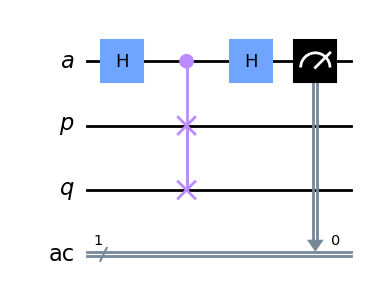

In [3]:
### Define classical register to measure to
ac = ClassicalRegister(1, name='ac')

swapTest = QuantumCircuit(a, phi, psi, ac)

swapTest.h(a)
swapTest.cswap(a, phi, psi)
swapTest.h(a)

swapTest.measure(a, ac)
swapTest.draw('mpl')

Job Status: job has successfully run


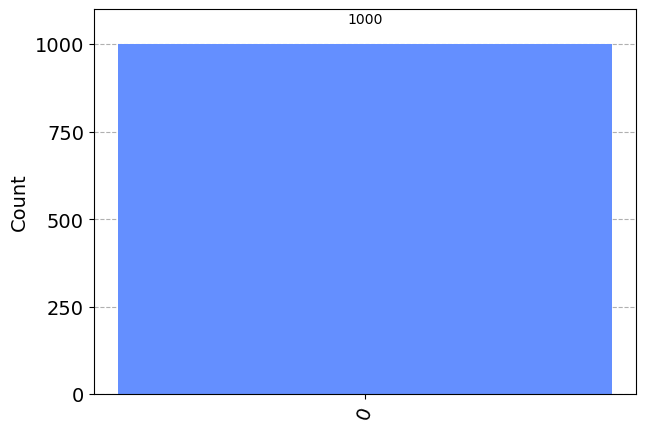

In [4]:
job = execute(swapTest, sim, shots=1000)
job_monitor(job)
counts = job.result().get_counts()
plot_histogram(counts)

Thus, we see that the states are the same, as expected. What if the states are orthogonal?

/home/kk423/.conda/envs/ML_env_mini/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


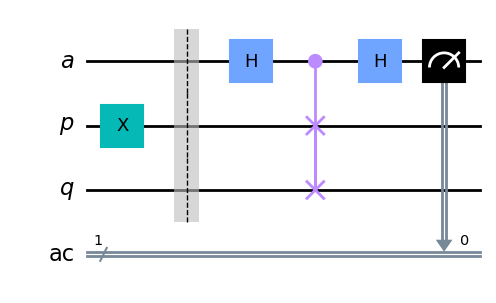

In [5]:
swapTest = QuantumCircuit(a, phi, psi, ac)

swapTest.x(phi)
swapTest.barrier()
swapTest.h(a)
swapTest.cswap(a, phi, psi)
swapTest.h(a)

swapTest.measure(a, ac)
swapTest.draw('mpl')


Job Status: job has successfully run


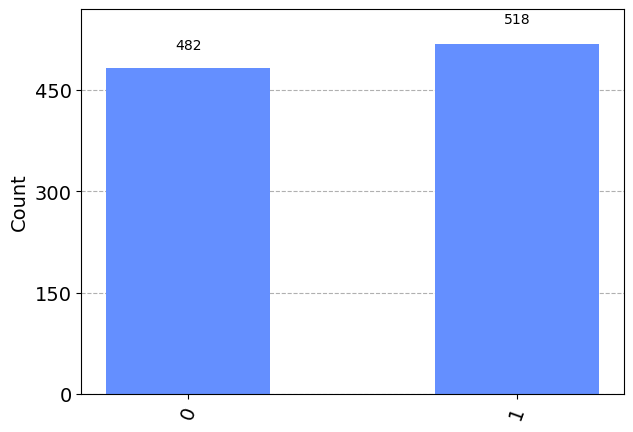

In [6]:
job = execute(swapTest, sim, shots=1000)
job_monitor(job)
counts = job.result().get_counts()
plot_histogram(counts)

## Calculating an Inner Product with the SWAP test

Now, let us consider the scenario where we want to calculate the inner product of the states $\vert \phi \rangle$ and $\vert \psi \rangle$, we can do this using the SWAP test. Rewriting the final state from above, we can see that the final state is

$$
\frac{1}{2}\vert 0 \rangle \otimes \big( \vert \phi \rangle \otimes \vert \psi \rangle + \vert \psi \rangle \otimes \vert \phi \rangle \big) + \frac{1}{2}\vert 1 \rangle \otimes \big( \vert \phi \rangle \otimes \vert \psi \rangle - \vert \psi \rangle \otimes \vert \phi \rangle\big).
$$

The probability of measuring the $\vert 0 \rangle$ on the ancilla qubit is therefore

$$
\textrm{Prob}( a = 0 ) = \frac{1}{2} + \frac{1}{2}\vert \langle \psi \vert \phi \rangle \vert ^2 ,
$$

which we can use to estimate the value of $\vert \langle \psi \vert \phi \rangle \vert ^2 $ to arbitrary accuracy as the number of shots on the device increases.  

## Exercise: Calculate an inner product

Calculate the inner product of two states $\vert \phi \rangle$ and $\vert \psi \rangle$ of your own choosing using what you have learned in this notebook. 

Hints:

First you need to initialise the two states $\vert \phi \rangle$ and $\vert \psi \rangle$ using the single qubit rotations from the start of the notebook.

Then you need to apply the SWAP test and then do postprocessing of the results to calculate the inner product. 

Use the simulator to remove the need for error mitigation.

/home/kk423/.conda/envs/ML_env_mini/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


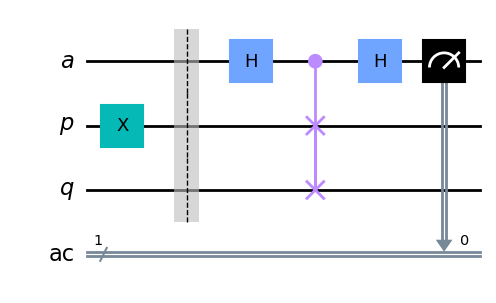

In [9]:
### Your code here
phi = QuantumRegister(1, name='p')
psi = QuantumRegister(1, name='q')
a   = QuantumRegister(1, name='a')
ac = ClassicalRegister(1, name='ac')

swapTest = QuantumCircuit(a, phi, psi, ac)
swapTest.x(phi)
swapTest.barrier()
swapTest.h(a)
swapTest.cswap(a, phi, psi)
swapTest.h(a)

swapTest.measure(a, ac)
swapTest.draw('mpl')

Job Status: job has successfully run


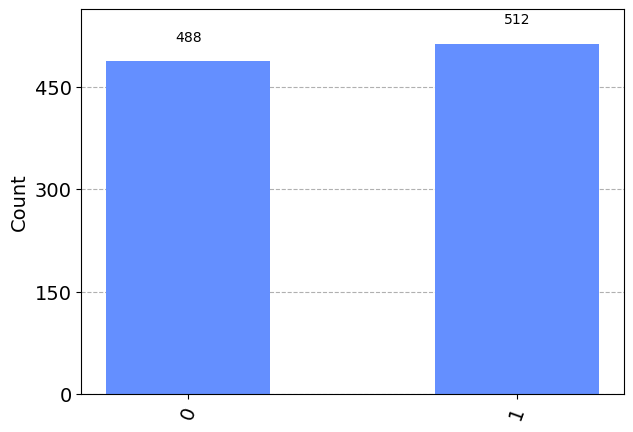

In [10]:
### Your code here
job = execute(swapTest, sim, shots=1000)
job_monitor(job)
counts = job.result().get_counts()
plot_histogram(counts)

In [11]:
### Your code here
print(counts['0'])
probability=counts['0']/1000
value= 2*(probability-1/2)
print(probability)
value

488
0.488


-0.02400000000000002

[1] Adriano Barenco, André Berthiaume, David Deutsch, Artur Ekert, Richard Jozsa, and Chiara Macchiavello, Stabilization of Quantum Computations by Symmetrization, https://doi.org/10.1137/S0097539796302452

[2] Harry Buhrman, Richard Cleve, John Watrous, and Ronald de Wolf, Quantum Fingerprinting, 10.1103/PhysRevLett.87.167902

## Qiskit - Bonus

## Building Noise Models

If you signed up to IBM Q Experience and tried running on a real device in the last exercise, you would have noticed that you have to wait in line for quite a while. If you want a quick idea of how your algorithm will perform on a real device, you can use a noise model. 

We show below the code to make a noisy simulation, following this [example](https://qiskit.org/documentation/tutorials/simulators/3_building_noise_models.html). Have an experiment and ask us if you get stuck. 

In [12]:
### Import required packages
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
                              pauli_error, depolarizing_error, thermal_relaxation_error)
from qiskit_aer import AerSimulator

/home/kk423/.conda/envs/ML_env_mini/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


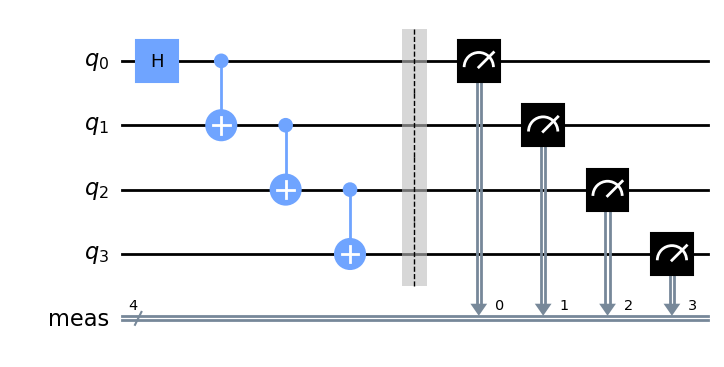

In [13]:
### Build circuit
n_qubits = 4
circ = QuantumCircuit(n_qubits)

circ.h(0)
for qubit in range(n_qubits - 1):
    circ.cx(qubit, qubit + 1)
circ.measure_all()
circ.draw('mpl')

Job Status: job has successfully run


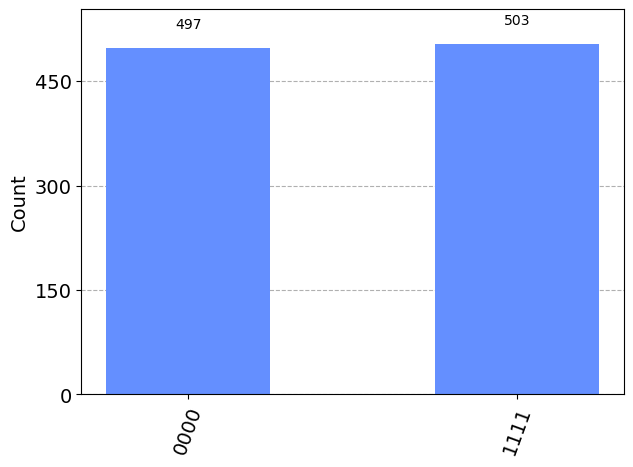

In [14]:
### Ideal simulation 
job = execute(circ, sim, shots=1000)
job_monitor(job)
counts = job.result().get_counts()
plot_histogram(counts)

In [15]:
### Example error probabilities
p_reset = 0.03
p_meas = 0.1
p_gate1 = 0.05

### QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas  = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)

### Add errors to noise model
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

print(noise_bit_flip)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u3', 'u1', 'measure', 'reset', 'cx', 'u2']
  All-qubits errors: ['reset', 'measure', 'u1', 'u2', 'u3', 'cx']


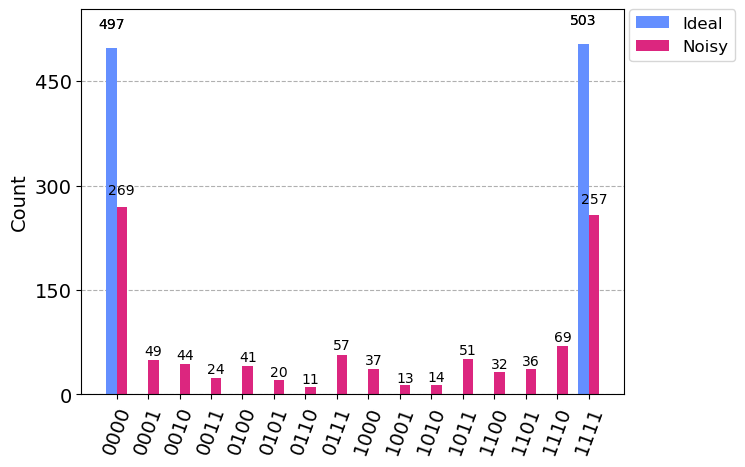

In [16]:
# Create noisy simulator backend
sim_noise = AerSimulator(noise_model=noise_bit_flip)

# Transpile circuit for noisy basis gates
circ_tnoise = transpile(circ, sim_noise)

# Run and get counts
result_bit_flip = sim_noise.run(circ_tnoise).result()
counts_bit_flip = result_bit_flip.get_counts(0)

# Plot noisy output
plot_histogram([counts, counts_bit_flip], legend=['Ideal', 'Noisy'])